# Monte Carlo Integration in $D$ Dimensions #
This notebook will give a brief introduction to $D$-dimensional numerical integration, comparing two naïve methods:
  * Riemann Sum
  * Monte Carlo integration with uniform sampling
 
## Riemann sum ##
The Riemann sum is perhaps the simplest and most intuitive numerical integration scheme. You want to integrate 
a function on an interval of length $x$. Divide your interval into $N$ sub-intervals of equal length $\Delta x = L/N$.
Evaluate the function in the middle of each sub-interval. The contribution to the total area from a sub-inteval 
with midpoint $x_i$ is then $f(x_i) \Delta x$, and the total value of the integral is
$$
\Delta x\sum_{i=1}^{N} f(x_i).
$$
The generalisation to $D$ dimensions is straightforward. Instead of having N equally spaced points along a line, you create an $D$-dimensional grid of points, with equal spacing, $\Delta x$, in all dimensions. The contribution to the total integral from a volume with center $\mathbf{x}_i$ is $f(\mathbf{x}_i) \cdot \Delta x^D$.

## Monte Carlo integration with uniform sampling ##
The simplest Monte Carlo integration scheme is essentially very similar to the Riemann sum method, except that the points where the function is to be evaluated are selected at random, instead of being equally spaced. Uniform sampling means that each point has the same probability of being selected. More advanced versions of Monte Carlo integration can for example use denser sampling in areas where the function value changes rapidly (*i.e.*, where the derivative of the function is large).

For a large number of random points, the integral obtained by the Monte Carlo method will approach the true value of the integral.

The generalisation to $D$ dimensions follows naturally in this case as well. Instead of selecting a random point along the line, we select a random point in $D$ dimensions, which amounts to generating $D$ random numbers in the right ranges and taking them as the coordinates of the point.

In [3]:
# Import numpy and matplotlib, and use jupyter magic to
# get plots directly in notebook
import numpy as np
import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt
# Get nicer looking plots than default
plt.style.use('bmh')
# We will need the gamma function for the analytical solution
# See http://en.wikipedia.org/wiki/Gamma_function for details
from math import gamma

## The volume of the unit sphere in $D$ dimensions ##

The problem we will use as an example is to determine the volume of the unit sphere, i.e., the sphere with radius 1, in $D$ dimensions. The answer is known analytically, and is
$$
V(r, D) = \frac{\pi^{D/2}}{\Gamma(D/2+1)}r^{D},
$$
or, with $r=1$,
$$
V(r, D) = \frac{\pi^{D/2}}{\Gamma(D/2+1)},
$$
(see http://en.wikipedia.org/wiki/Volume_of_an_n-ball for details)

In [4]:
# This function returns 1 if a point is inside the unit sphere, 0 otherwise.
# The notation *X allows the function to take a variable number of arguments,
# which are available as a tuple inside the function. By converting the tuple
# to a numpy array, we can treat it as a D-dimensional vector, and find its 
# length by taking the root of the sum of the squares.
def unitSphere(*X):
    R = 1
    r = 0
    X = np.array(X)
    r = np.sqrt(np.sum(X**2))
    if r < R:
        return 1
    else:
        return 0

# This line performs some numpy magic on the function, allowing it to operate
# elementwise when called with an array as its argument. In this way, we can
# for example call this function with a rank 3 array, and have it interpreted
# as a rank 2 array of vectors.
unitSphere = np.vectorize(unitSphere)

# This function returns the volume of the unit sphere (r=1) in d dimensions
def v(D):
    return np.pi**(D/2.0) / gamma(1+D/2.0)

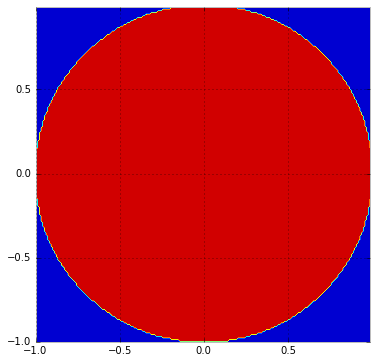

In [5]:
# This piece of code plots the unit sphere in 2 dimensions.
# It is of course also possible to plot in 3 dimensions, but the 
# matplotlib code gets a bit more involved.
X = np.arange(-1, 1, 0.01)
Y = np.arange(-1, 1, 0.01)
X, Y = np.meshgrid(X, Y)
plt.clf()
plt.figure(figsize = (6,6))
plt.contourf(X, Y, unitSphere(X, Y))

## Number of points ##

With the Monte Carlo method, it's easy to use any number of points you like, but with the Riemann sum you are limited by the regular grid. For simplicity, let's stick to the same spacing in each direction. Say we want to integrate from -1 to 1 along the $x$ direction, and split this interval into $N_x$ subintervals. Doing the same along the other dimensions give a total of $N=N_x^D$ points. To keep things nice and comparable, we will use the same number of points with both methods, and write both functions so they take $N_x$ as an argument and figure out the total from that.

## Riemann sum integrator ##

In [6]:
# This function takes as its arguments
# f     - a function to be integrated
# Nx    - number of points along each dimension of the regular grid
# D     - number of dimensions
# start - start of integration interval (same for all dimensions)
# stop  - end of integration interval (same for all dimensions)
def riemannSum(f, Nx, D, start, stop):
    # Calculate the spacing
    dx = (stop - start)/float(Nx)
    # Calculate the coordinates of the gridpoints along one dimension
    # The coordinates for the other dimensions will be the same
    x = np.linspace(start+dx/2, stop-dx/2, Nx)
    # Calculate the volume surrounding each grid point
    vol = dx**D
    # The one-dimensional case is handled specially, because np.meshgrid
    # doesn't work with only one argument
    if D == 1:
        points = [x]
    else:
        # This bit may not be intuitively obvious, as there is quite a lot
        # going on at once. See explanation in the Appendix. Essentially, 
        # this line assigns a rank 2 array with shape (D, N) to the variable
        # points. Each of the N columns represents a D vector which holds the
        # the coordinates of a point in the grid.
        points =  np.array(np.meshgrid(*[x]*D)).reshape(D, -1)
    # Here, f is called on each point in the grid, and the sum times the volume
    # of each cell is returned
    return np.sum(f(*points))*vol


In [7]:
# This function takes as its arguments
# f     - a function to be integrated
# Nx    - number of points along each dimension of the regular grid
# D     - number of dimensions
# start - start of integration interval (same for all dimensions)
# stop  - end of integration interval (same for all dimensions)
def monteCarloIntegrator(f, Nx, D, start, stop):
    # Calculate the total number of points
    N = Nx**D
    # Calculate the volume represented by each point as the total
    # integration volume divided by the number of points. You can
    # easily confirm that this is the same as the volume used in the
    # Riemann sum function.
    vol = (float(stop - start)**D) / N
    # Generate a rank 2 array of shape(D, N) filled with uniformly distributed
    # random numbers between start and stop. Each of the N columns represents a
    # D vector which holds the coordinates of one of the random points.
    points = np.random.random((D, N))*(stop - start) + start
    # Here, f is called on each point in the grid, and the sum times the volume
    # of each cell is returned
    return np.sum(f(*points))*vol

## Application ##

It's hard to have an intuitive feeling for things in many dimensions. We therefore select a maximum number of points that we want to use, and calculate the highest possible $N_x$ that fits.

In [9]:
Nmax = 500000                # Upper limit on number of points
D = 8                        # Number of dimensions
start = -1                   # Start of integration interval (same for all dimensions)
stop  = 1                    # End of integration interval (same for all dimensions)
Nx = int(Nmax**(1.0/D))      # Calculate max number of points along each dimension
N  = Nx**D                   # Calculate the total number of points used
print('Nx:           ', Nx)
print('N:            ', N)
print('Analytic:     ', v(D))
print('Monte Carlo:  ', monteCarloIntegrator(unitSphere, Nx, D, start, stop))
print('Riemann Sum:  ', riemannSum(unitSphere, Nx, D, start, stop))

Nx:            5
N:             390625
Analytic:      4.058712126416768
Monte Carlo:   4.05536768
Riemann Sum:   4.4990464


## Results ##
By experimenting a bit with different numbers, you should realise a couple of things
 * If the number of dimensions is small, both these methods perform ok
 * If the number of dimensions is large, the total number of points grows extremely fast with $N_x$
 * If the number of dimensions is large (8 or 10, for example), the Monte Carlo method works better

So why does the Monte Carlo method work better? In this particular case (integrating a function which only depends on $r$), I think it is due to the fact that with a regular grid, there will be a large number of points that have the same distance from the origin. Adjusting the resolution will thus move a lot of points inside or outside the unit sphere at the same time, causing the Riemann sum to over- or underestimate the answer in most cases. With the Monte Carlo method, the points will have a better distribution in terms of distance from the origin.

Again, this example was chosen specifically to show that the Monte Carlo method can perform better than the Riemann sum, but the general point that Monte Carlo methods tend to perform better in higher dimensions hold.

## Appendix ##

In [28]:
points =  np.array(np.meshgrid(*[x]*D)).reshape(D, -1)

What does this line of code actually do? Let's have a look at it piece by piece.

In [10]:
# np.meshgrid takes n arrays as arguments (where n > 1), and returns n rank n arrays, which only change along one direction.
# It is easiest to grasp with an example. Say you have two vectors, X and Y:
X = np.arange(0, 5)
Y = np.arange(5, 10)
print('X = ', X)
print('Y = ', Y)

X =  [0 1 2 3 4]
Y =  [5 6 7 8 9]


In [11]:
# Then, say you want to create a grid of points, for example for plotting,
# where the x coordinates are given by X, and the y coordinates by Y, 
# such that the first point would be (0, 5), the second point (1,5), ...
# the sixth point (0, 6), etc.
# This is facilitated by np.meshgrid:
Xs, Ys = np.meshgrid(X, Y)
print('Xs = ', Xs)
print('Ys = ', Ys)

Xs =  [[0 1 2 3 4]
 [0 1 2 3 4]
 [0 1 2 3 4]
 [0 1 2 3 4]
 [0 1 2 3 4]]
Ys =  [[5 5 5 5 5]
 [6 6 6 6 6]
 [7 7 7 7 7]
 [8 8 8 8 8]
 [9 9 9 9 9]]


In [31]:
# When combining one element from the array Xs, with the corresponding
# element from the array Ys, we get the coordinates of each point.
# Although perhaps not immediately obvious, this generalises to more than
# two dimensions as well. In our case, we create an array, x, of points in
# the x-direction, which we want to use in all directions. In D dimensions, 
# we can achieve this by calling meshgrid on D copies of the array x.
# In python a list multiplied with a number n is a list containing the elements
# of the original list repeated n times:
print([1,2,3] * 3)

[1, 2, 3, 1, 2, 3, 1, 2, 3]


In [32]:
# Note that this is very different from multiplying a numpy array by a number:
print(np.array([1,2,3]) * 3)

[3 6 9]


In [12]:
# Thus, the code [x]*D makes a list of D elements, where each element is
# the array x:
x = np.array([1,2])
print([x]*2)

[array([1, 2]), array([1, 2])]


In [34]:
# The code np.meshgrid(*[x]*D) uses the * to "unpack" the list created by [x]*D
# thus effectively calling the function meshgrid with D arguments,
# each of which is a copy of the array x
# np.meshgrid(*[x]*3)
# is exactly the same as 
# np.meshgrid(x, x, x)

In [35]:
# Meshgrid returns a tuple of D arrays. This can be turned into an array
# of arrays, which is the same as an array of one higher rank. Again, an
# example is probably easiest:

# Creating a rank 1 array
a = np.array([1,2])
# Creating a tuple of two rank 1 arrays
b = (a, a)
print(b)
# Turning the tuple into a rank 2 array
print(np.array(b))

(array([1, 2]), array([1, 2]))
[[1 2]
 [1 2]]


In [13]:
# So, finally, the line in question produces an array of rank D+1, which
# is reshaped into a rank 2 array with shape (D, N) where D is the number of dimensions
# and N is the number of points, and where each column is a D-vector which gives 
# the coordinates of one point.

# For small numbers, it can be verified by inspection that each column does
# indeed give the coordinates of a unique point:
D = 3
x = np.array([0,1,2])
points =  np.array(np.meshgrid(*[x]*D)).reshape(D, -1)
print(points)

[[0 0 0 1 1 1 2 2 2 0 0 0 1 1 1 2 2 2 0 0 0 1 1 1 2 2 2]
 [0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2]
 [0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2]]
